# Comparison Notebook

This notebook is intended to compare the output of a MaxQuant run to a AlphaPept run.

## What is still missing?

- [ ] More coverage when comparing the settings
    * Peak paramaters (i.e. retention length)
    *  Why does MQ have peaks with Retention Length of exactly 1?
- [ ] Only a single file atm -> No comparison of MatchBetweenRuns / MaxLFQ
- [ ] Check sequences that have a high score and are different

## Compare MaxQuant to AlphaPept Parameters

In [ ]:
#Get maxquant parameters, as dict
import xml.etree.ElementTree as ET

mq_par = 'F:/rawdata/04_hela_testrun/mqpar.xml'

tree = ET.parse(mq_par)
root = tree.getroot()


def extract_nested(child):
    if len(child) > 0:
        temp_dict = {}
        for xx in child:
            temp_dict[xx.tag] = extract_nested(xx)
        return temp_dict
    else:
        if child.text == 'True':
            info = True
        elif child.text == 'False':
            info = False
        else:
            info = child.text
        return info

mq_dict = {}

for child in root:  

    mq_dict[child.tag] = extract_nested(child)

## Load AlphaPept Settings

Load the AlphaPept yaml file.

In [ ]:
import yaml

ap_settings_path = 'F:/rawdata/04_hela_testrun/20190402_QX1_SeVW_MA_HeLa_500ng_LC11_ap.yaml'

with open(ap_settings_path) as f:
    settings = yaml.load(f, Loader=yaml.FullLoader)

## Compare AlphaPept to MaxQuant
Compare the different fields. Return a `coverage` which is the total number of fields vs the number of compared fields.

In [ ]:
#Comparing settings
import os
import pandas as pd

n_keys = len(mq_dict.keys())

compared = []

fasta_chk = os.path.normpath(mq_dict['fastaFiles']['FastaFileInfo']['fastaFilePath']) == os.path.normpath(settings['fasta']['fasta_path'])
compared.append(('fasta',fasta_chk))

contaminant_chk = mq_dict['includeContaminants'] == (settings['fasta']['contaminants_path'] is not None)
compared.append(('contaminants',contaminant_chk))

cleavage_chk = mq_dict['includeContaminants'] == (settings['fasta']['contaminants_path'] is not None)
compared.append(('missed_cleavages',cleavage_chk))

print('Comparison Coverage {} %'.format(len(compared)/n_keys*100))
pd.DataFrame(compared, columns=['Parameter','Equal'])

Comparison Coverage 2.4 %


,Parameter,Equal
0,fasta,True
1,contaminants,True
2,missed_cleavages,True


## Load files

In [ ]:
#Analyze statistics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

path = 'F:/rawdata/04_hela_testrun/20190402_QX1_SeVW_MA_HeLa_500ng_LC11_ap.csv'
df = pd.read_csv(path)

mq_evid_path = 'F:/rawdata/MQ_1_6_14/MaxQuant_1.6.14/MaxQuant/combined/txt/evidence.txt'
mq_evidence = pd.read_csv(mq_evid_path, sep='\t')

software_1 = 'AlphaPept'
software_2 = 'MaxQuant'

In [ ]:
def parse_mq_seq(peptide):
    """
    Replaces maxquant convention to alphapept convention
    ToDo: include more sequences
    """
    peptide = peptide[1:-1] #Remove _

    peptide = peptide.replace('(Acetyl (Protein N-term))','a')
    peptide = peptide.replace('M(Oxidation (M))','oxM')
    
    peptide = peptide.replace('C','cC') #This is a fixed mod, so it seems to be not indicated
    
        
    return peptide

## Summary statistics

In [ ]:
#Rename the lables to make them comparabel
df1 = df.copy()

# add sequence charge
df1['sequence_charge'] = df['sequence'].values + df['charge'].values.astype('int').astype('str')
df1['missed_cleavages'] = df1['sequence'].str[:-1].str.count('K') + df1['sequence'].str[:-1].str.count('R')


df2 = mq_evidence.copy()

#Convert maxquant

df2['charge'] = df2['Charge']

list_2 = mq_evidence['Modified sequence'].values
list_2 = [parse_mq_seq(_) for _ in list_2]
df2['sequence'] = list_2

list_2 = [''.join(_) for _ in zip(list_2, mq_evidence['Charge'].values.astype('int').astype('str'))]

df2['sequence_charge'] = list_2
df2['protein'] = df2['Leading razor protein']
df2['decoy'] = df2['Reverse'] == '+'
df2['score'] = df2['Score']

df2['int_sum'] = df2['Intensity']

df2['missed_cleavages'] = df2['sequence'].str[:-1].str.count('K') + df2['sequence'].str[:-1].str.count('R')


In [ ]:
def compare_field(df1, df2, software_1, software_2, field, exclude_decoy=True):
    
    title_dict = {'protein':'Number of unique proteins',
                 'sequence': 'Number of unique peptide sequences',
                 'sequence_charge':'Number of unique sequence/charge combinations',
                 'charge':'Occurence of charge states',
                 'digestion':'Occurence of last AA in sequence',
                 'total_missed_cleavages':'Total number of missed cleavages',
                 'missed_cleavages':'Ratio of number of of missed cleavages'}#nicer descriptions for the plots
    
    if exclude_decoy:
        df1 = df1[~df1['decoy']]
        df2 = df2[~df2['decoy']]
    
    #Some pre-defined boundaries
    plt.figure(figsize=(5,5))
    
    if field == 'charge':
        ratios = df1[field].value_counts() / df2[field].value_counts()
        plt.axhline(1, color='k', linestyle=':')
        plt.bar(ratios.index, ratios.values, label='Ratio {}/{}'.format(software_1, software_2))
        plt.legend()
        #bins = np.arange(1,6,0.5)
        
        #plt.hist(df1[field].values, bins=bins,label=software_1)
        #plt.hist(df2[field].values-0.5, bins=bins, label=software_2)
        
        plt.legend()
        
    elif (field == 'protein') or (field == 'sequence') or (field == 'sequence_charge'):
        plt.bar(software_1, len(set(df1[field])))
        plt.bar(software_2, len(set(df2[field])))
        
    elif (field == 'digestion'):
        ratios = df1['sequence'].str[-1].value_counts() / df2['sequence'].str[-1].value_counts()
        plt.axhline(1, color='k', linestyle=':')
        plt.bar(ratios.index, ratios.values, label='Ratio {}/{}'.format(software_1, software_2))
        plt.legend()
        
        
    elif (field == 'total_missed_cleavages'):
        field_ = 'missed_cleavages'
        plt.bar(software_1, df1[field_].sum())
        plt.bar(software_2, df2[field_].sum())
        
        
    elif (field == 'missed_cleavages'):
        ratios = df1[field].value_counts() / df2[field].value_counts()
        plt.axhline(1, color='k', linestyle=':')
        plt.bar(ratios.index, ratios.values, label='Ratio {}/{}'.format(software_1, software_2))

    else:
        raise NotImplementedError
        
    plt.title(title_dict[field])
    plt.show()


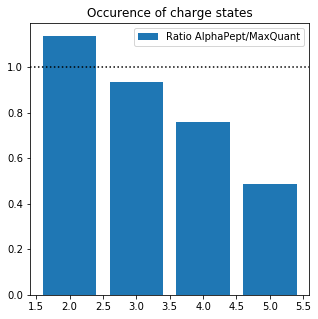

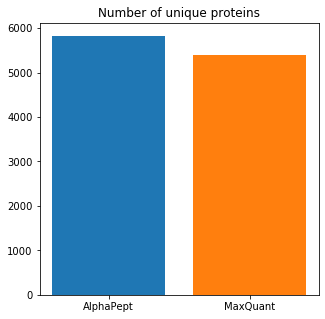

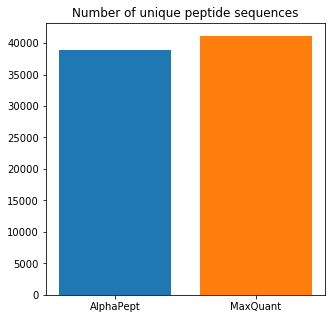

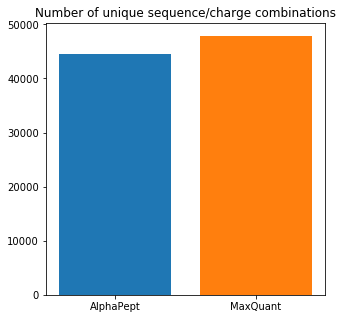

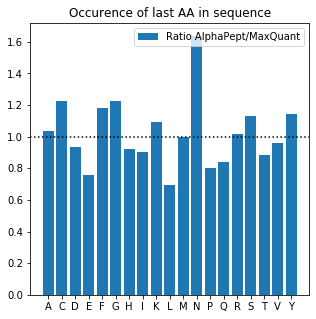

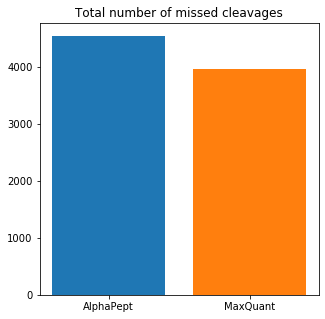

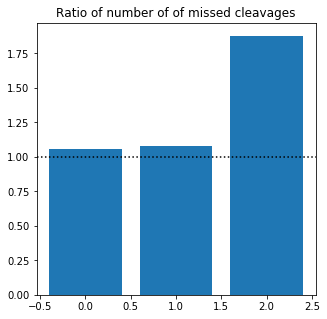

In [ ]:
for field in ['charge','protein','sequence','sequence_charge', 'digestion', 'total_missed_cleavages',  'missed_cleavages']:
    compare_field(df1, df2, software_1, software_2, field)

## Union Plots

Union plots displaying the shared peptides / proteins.

In [ ]:
from matplotlib_venn import venn2
def compare_populations(df1, df2, software_1, software_2, field, exclude_decoy=True):
    """
    Compare to lists of peptides / proteins
    
    Convention: all should be uppercase
    ToDo: check this maybe
    """
    
    title_dict = {'protein':'Shared proteins',
                 'sequence': 'Shared peptide sequences',
                 'sequence_charge':'Shared sequence/charge combinations',
                 } 
    
    if exclude_decoy:
        df1 = df1[~df1['decoy']]
        df2 = df2[~df2['decoy']]
        
    list_1 = df1[field].values
    list_2 = df2[field].values
    
    peptides_1 = set(list_1)
    peptides_2 = set(list_2)
    n_1 = len(peptides_1 - peptides_2)
    n_2 = len(peptides_2 - peptides_1)
    shared = len(peptides_1.intersection(peptides_2))
    
    
    venn2(subsets = (n_1, n_2, shared), set_labels = (software_1, software_2))
    plt.title(title_dict[field])
    plt.show()

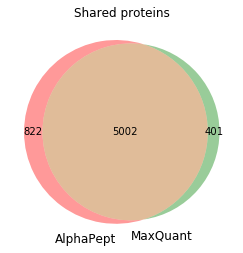

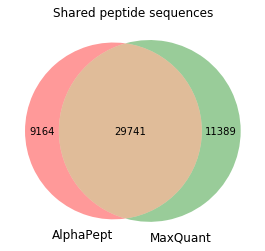

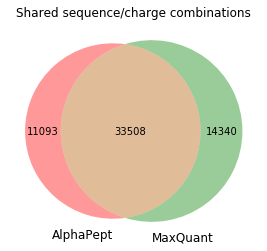

In [ ]:
for field in ['protein','sequence','sequence_charge']:
    compare_populations(df1, df2, software_1, software_2, field)

## Shared elements and score

Are the elements that are not shared likely to have a low score?

In [ ]:
def compare_by_score(df1, df2, software_1, software_2, field, exclude_decoy=True):

    exclude_decoy = True

    if exclude_decoy:
        df1 = df1[~df1['decoy']]
        df2 = df2[~df2['decoy']]

    list_1 = df1[field].values
    list_2 = df2[field].values

    df1 = df1.set_index(field)
    df2 = df2.set_index(field)

    peptides_1 = set(list_1)
    peptides_2 = set(list_2)
    n_1 = len(peptides_1 - peptides_2)
    n_2 = len(peptides_2 - peptides_1)
    shared = len(peptides_1.intersection(peptides_2))

    only_1 = peptides_1-peptides_2
    only_2 = peptides_2-peptides_1
    common = peptides_1.intersection(peptides_2)

    score_only_1 = df1.loc[only_1]['score'].values
    score_common_1 = df1.loc[common]['score'].values

    score_only_2 = df2.loc[only_2]['score'].values
    score_common_2 = df2.loc[common]['score'].values

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    fig.suptitle('Score Distributionfor {}'.format(field))

    bins = np.linspace(df1['score'].min(), df1['score'].max(), 30)

    ax1.hist(score_common_1, bins = bins, alpha=0.7, label='Shared')
    ax1.hist(score_only_1, bins = bins, alpha=0.7, label='Only {}'.format(software_1))
    ax1.legend()

    bins = np.linspace(df2['score'].min(), df2['score'].max(), 30)

    ax2.hist(score_common_2, bins = bins, alpha=0.7, label='Shared')
    ax2.hist(score_only_2, bins = bins, alpha=0.7, label='Only {}'.format(software_2))
    ax2.legend()
    plt.show()

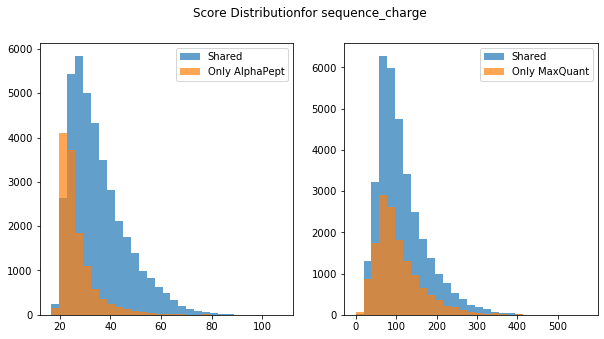

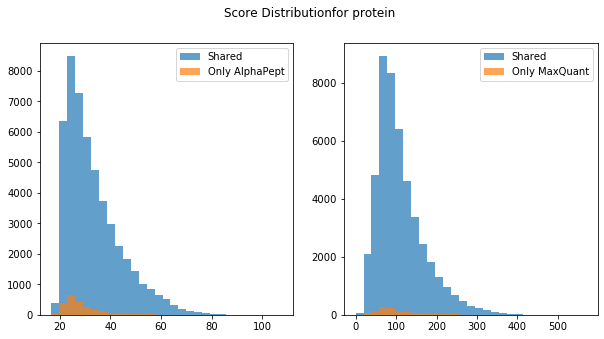

In [ ]:
compare_by_score(df1, df2, software_1, software_2, 'sequence_charge', exclude_decoy=True)
compare_by_score(df1, df2, software_1, software_2, 'protein', exclude_decoy=True)

## Intensity Correlation

Take the maximum intensity for each sequence

In [ ]:
ref_df1 = df1.copy()
ref_df2 = df2.copy()

ref_df1 = ref_df1[['sequence_charge','int_sum','score']]
ref_df2 = ref_df2[['sequence_charge','int_sum','score']]

ref_df1 = ref_df1.groupby('sequence_charge').max()
ref_df2 = ref_df2.groupby('sequence_charge').max()

shared = set(ref_df1.index.values).intersection(set(ref_df2.index.values))

In [ ]:
import seaborn as sns

<Figure size 504x504 with 0 Axes>

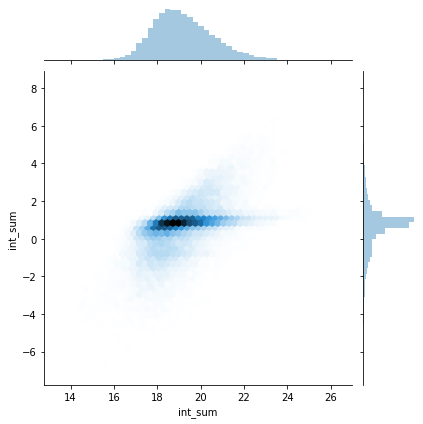

Mean log 0.59 - Ratio 1.81 of AlphaPept/MaxQuant


In [ ]:
plt.figure(figsize=(7,7))
x = np.log(ref_df1.loc[shared]['int_sum'])
y = np.log(ref_df1.loc[shared]['int_sum'] / ref_df2.loc[shared]['int_sum'])
sns.jointplot(x = x, y = y, kind ="hex")

plt.show()

print('Mean log {:.2f} - Ratio {:.2f} of {}/{}'.format(np.mean(y), np.exp(np.mean(y)), software_1, software_2))

## Score correlation

<Figure size 504x504 with 0 Axes>

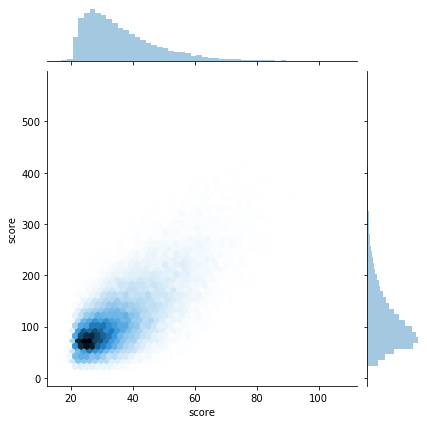

In [ ]:
plt.figure(figsize=(7,7))
x = ref_df1.loc[shared]['score']
y = ref_df2.loc[shared]['score']
sns.jointplot(x = x, y = y, kind ="hex")
plt.show()

## Proteins

* We need to check protein groups again

* What is the difference between leading proteins and leading proteins razor?

In [ ]:
ref_df1 = df1.copy()
ref_df2 = df2.copy()

d1 = ref_df1[['protein','int_sum']].groupby('protein').sum()
d2 = ref_df2[['protein','int_sum']].groupby('protein').sum()

shared = set(d1.index.values).intersection(set(d2.index.values)) 

C:\ProgramData\Anaconda3\envs\alphap\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Figure size 504x504 with 0 Axes>

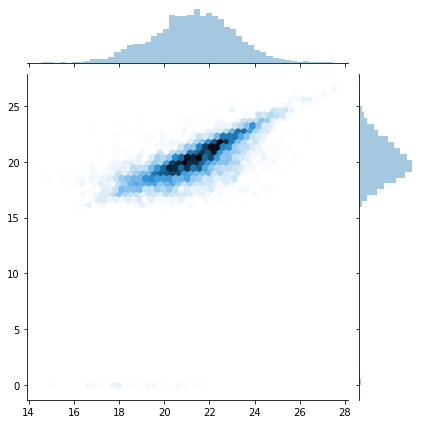

Mean log 20.03 - Ratio 499992546.34 of AlphaPept/MaxQuant


In [ ]:
plt.figure(figsize=(7,7))
x = np.log(d1.loc[shared]['int_sum']).values
y = np.log(d2.loc[shared]['int_sum']).values

y[np.isinf(y)] = 0
sns.jointplot(x= x, y = y, kind ="hex")

plt.show()

print('Mean log {:.2f} - Ratio {:.2f} of {}/{}'.format(np.mean(y), np.exp(np.mean(y)), software_1, software_2))

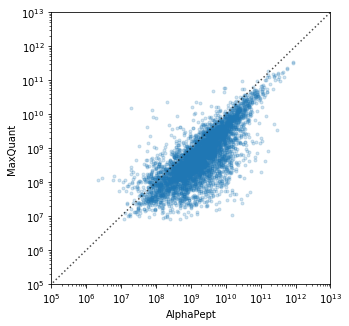

In [ ]:
plt.figure(figsize=(5,5))
plt.scatter(d1.loc[shared]['int_sum'].values, d2.loc[shared]['int_sum'].values, alpha=0.2, marker='.')
plt.xscale('log')
plt.yscale('log')

plt.xlabel(software_1)
plt.ylabel(software_2)

plt.plot([0,1e13], [0,1e13], 'k:', alpha=0.7)

plt.xlim([1e5,1e13])
plt.ylim([1e5,1e13])

plt.show()

## Protein Ranks

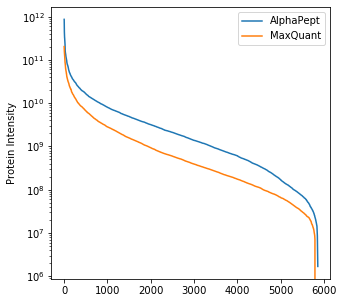

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

data_1 = df[['protein','int_apex','int_sum']].groupby('protein').sum()
data_1 = data_1.sort_values(by='int_sum', ascending=False) #.head(20)

data_2 = mq_evidence[['Leading proteins','Intensity']].groupby('Leading proteins').sum()
data_2 = data_2.sort_values(by='Intensity', ascending=False) #.head(20)


plt.figure(figsize=(5,5))
plt.plot(data_1['int_sum'].values, label=software_1)
plt.plot(data_2['Intensity'].values, label=software_2)
plt.yscale('log')
plt.legend()
plt.ylabel('Protein Intensity')
plt.show()